In [6]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2
import random
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import json

In [7]:
df = pd.read_csv('../input/diabetic-retinopathy-224x224-gaussian-filtered/train.csv')
df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [8]:
diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,type
0,000c1434d8d7,2,Moderate
1,001639a390f0,4,Proliferate_DR
2,0024cdab0c1e,1,Mild
3,002c21358ce6,0,No_DR
4,005b95c28852,0,No_DR


In [9]:
def merge_value(data):
    if data==1 or data==2 or data==3 or data==4:
        return np.int64(1)
    else:
        return np.int64(0)

In [10]:
df['diagnosis'] = df['diagnosis'].apply(merge_value)

In [11]:
diagnosis_dict_btype = {
    0: 'No_DR',
    1: 'DR'
}
df['b_type'] = df['diagnosis'].map(diagnosis_dict_btype.get)
df.head()

,id_code,diagnosis,type,b_type
0,000c1434d8d7,1,Moderate,DR
1,001639a390f0,1,Proliferate_DR,DR
2,0024cdab0c1e,1,Mild,DR
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


1    1857
0    1805
Name: diagnosis, dtype: int64

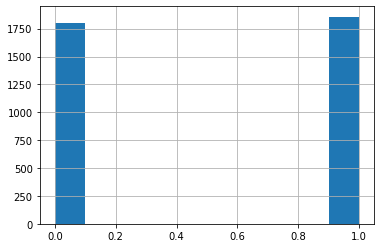

In [12]:
df['diagnosis'].hist()
df['diagnosis'].value_counts()

In [13]:
train_intermediate, val = train_test_split(df, test_size = 0.2)
train, test = train_test_split(train_intermediate, test_size = 0.2 / (1 - 0.2))

print(train['diagnosis'].value_counts(), '\n')
print(test['diagnosis'].value_counts(), '\n')
print(val['diagnosis'].value_counts(), '\n')

0    1104
1    1092
Name: diagnosis, dtype: int64 

1    380
0    353
Name: diagnosis, dtype: int64 

1    385
0    348
Name: diagnosis, dtype: int64 



In [14]:
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [15]:
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [16]:
src_dir = '../input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['b_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['b_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)
 
for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['b_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

In [17]:
def image_preproc(image):
    image = cv2.resize(image,(224,224))
    image= tf.image.adjust_contrast(image, 0.6)
    image = tfa.image.equalize(image)
    return image

In [18]:
train_path = './train'
val_path = './val'
test_path = './test'

train_batches = ImageDataGenerator(rescale = 1./255,preprocessing_function=image_preproc).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255,preprocessing_function=image_preproc).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255,preprocessing_function=image_preproc).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

Found 2196 images belonging to 2 classes.
Found 733 images belonging to 2 classes.
Found 733 images belonging to 2 classes.


2021-12-09 11:12:49.622178: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-09 11:12:49.753783: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-09 11:12:49.754933: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-09 11:12:49.758314: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


<Figure size 432x288 with 0 Axes>

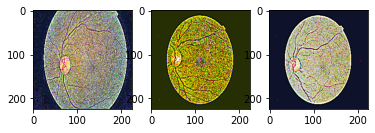

In [19]:
plt.figure()
f, axarr = plt.subplots(1,3)
for i in range (0,3):
    random_num = random.randint(0,40)
    image = train_batches[random_num]
    axarr[i].imshow(image[0][0])
    print(np.shape(image[0][0]))

In [20]:
base_model = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False, weights='imagenet',
    input_shape=(224,224,3))

87924736/87910968 [==============================] - 2s 0us/step


In [21]:
def build_model():
    model = tf.keras.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(2, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-6),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])
    return model

In [22]:
def build_model():
    model = tf.keras.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(2, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-6),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])
    return model
base_model = tf.keras.applications.inception_v3.InceptionV3(include_top=False, 
            weights='imagenet',input_shape=(224,224,3))
model = build_model()
history = model.fit(train_batches,
          epochs=60,validation_data=val_batches,
          callbacks=EarlyStopping(monitor="val_loss", 
          patience=5, 
          restore_best_weights=True))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 21,772,450
Non-trainable params: 34,432
_________________________________________________________________


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [23]:
history = model.fit(train_batches,
                    epochs=60,
                    validation_data=val_batches,callbacks=EarlyStopping(monitor="val_loss", patience=5, 
                    restore_best_weights=True))

Epoch 1/60


2021-12-09 11:13:13.389867: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


69/69 [==============================] - 68s 740ms/step - loss: 0.6904 - acc: 0.5783 - val_loss: 0.7922 - val_acc: 0.4775
Epoch 2/60
69/69 [==============================] - 48s 700ms/step - loss: 0.6027 - acc: 0.6858 - val_loss: 0.6630 - val_acc: 0.4993
Epoch 3/60
69/69 [==============================] - 48s 700ms/step - loss: 0.5414 - acc: 0.7755 - val_loss: 0.5289 - val_acc: 0.6821
Epoch 4/60
69/69 [==============================] - 47s 689ms/step - loss: 0.4827 - acc: 0.8452 - val_loss: 0.4513 - val_acc: 0.8281
Epoch 5/60
69/69 [==============================] - 48s 703ms/step - loss: 0.4314 - acc: 0.8848 - val_loss: 0.3997 - val_acc: 0.8772
Epoch 6/60
69/69 [==============================] - 47s 686ms/step - loss: 0.3868 - acc: 0.9003 - val_loss: 0.3616 - val_acc: 0.9072
Epoch 7/60
69/69 [==============================] - 48s 694ms/step - loss: 0.3609 - acc: 0.9107 - val_loss: 0.3331 - val_acc: 0.9127
Epoch 8/60
69/69 [==============================] - 48s 693ms/step - loss: 0.327

<AxesSubplot:>

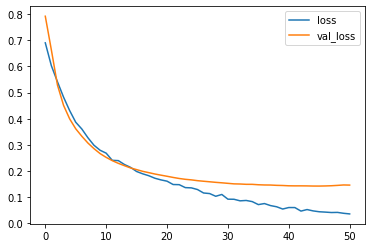

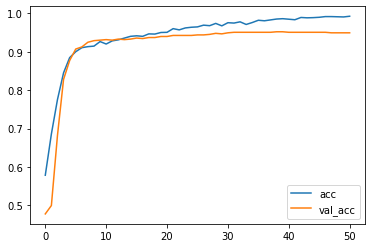

In [32]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

In [33]:
model.save('InceptionV3U.h5')

In [34]:
from tensorflow.keras.models import load_model
savedModel=load_model('InceptionV3U.h5')

In [35]:
test_eval = savedModel.evaluate(test_batches)
print(f'test loss, test acc: {test_eval}')

23/23 [==============================] - 13s 481ms/step - loss: 0.1560 - acc: 0.9523
test loss, test acc: [0.15599586069583893, 0.9522510170936584]


In [36]:
predictions = savedModel.predict(test_batches)

In [37]:
from sklearn.metrics import confusion_matrix,classification
from sklearn.metrics import classification_report

In [38]:
y_pred=predictions.argmax(axis=1)
y_true = test_batches.labels

In [40]:
print(confusion_matrix(y_pred,y_true))
print("\n\n")
print(classification_report(y_pred,y_true))

[[360  15]
 [ 20 338]]



              precision    recall  f1-score   support

           0       0.95      0.96      0.95       375
           1       0.96      0.94      0.95       358

    accuracy                           0.95       733
   macro avg       0.95      0.95      0.95       733
weighted avg       0.95      0.95      0.95       733

